# the main goal of this notebook is to train our multi-task model
going to add a simple FC layer to one of the pyramid features in the forward pass of retinanet. Also, this model may or may not have separate NMS protocols for hands and tools...

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import argparse
import collections
from pathlib import Path
import csv
import os 

import numpy as np 

import torch
import torch.optim as optim
from torchvision import transforms, utils as vision_utils 
#from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.insert(0, '/pasteur/u/egoodma/multitaskmodel/MULTITASK_FILES/RETINANET_FILES/src/pytorch-retinanet/')
from retinanet import model
from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, \
    Normalizer, BalancedSampler
from torch.utils.data import DataLoader

from retinanet.sampler import SamplerFactory, aggregate_indices_per_class 


from retinanet import coco_eval
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'
LOGS_DIR = '/pasteur/u/egoodma/projects/logs/'

print('CUDA available: {}'.format(torch.cuda.is_available()))

Adding new multi-task model to path!


/pasteur/u/egoodma/MINICONDA/envs/actionshandstools/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/pasteur/u/egoodma/MINICONDA/envs/actionshandstools/lib/python3.8/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


CUDA available: True


In [4]:
### Set up model configs ### 

parser = argparse.ArgumentParser(description='Simple training script for training a RetinaNet network.')

parser.add_argument('--dataset', help='Dataset type, must be one of csv or coco.')
parser.add_argument('--coco_path', help='Path to COCO directory')
parser.add_argument('--csv_train', help='Path to file containing training annotations (see readme)')
parser.add_argument('--csv_classes', help='Path to file containing class list (see readme)')
parser.add_argument('--csv_val', help='Path to file containing validation annotations (optional, see readme)')
parser.add_argument('--depth', help='Resnet depth, must be one of 18, 34, 50, 101, 152', type=int, default=50)
parser.add_argument('--epochs', help='Number of epochs', type=int, default=100)
parser.add_argument('--model_name', help='Name to store the trianed model under.')
parser.add_argument('--log_output', help='Save output to csv file', action='store_true')
parser.add_argument('--batch_size', type=int)
parser.add_argument('--learning_rate', type=float)
parser.add_argument('--threshold', help='iou threshold to count as detection')
parser.add_argument('--sampler', help='Type of sampler to use, default aspect ratio sampler.')
parser.add_argument('--augment', action='store_true')
parser.add_argument('--pretrained', help='Path to pretrained model')
parser.add_argument('--blacken', action='store_true')

##### PRIMARY MODEL CONFIGS TO SET ### 

parser.model_name = '12.13_rain_model_90pc_aug' 

#some augmentation parameters
parser.augment = 0
parser.pipeline = False
parser.sampler = None 
parser.alpha = 0


#relevant parms
parser.epochs = 200
parser.num_workers = 0





parser.dataset = 'csv' 
parser.csv_train = '/pasteur/u/egoodma/projects/rain_train_data.csv' #'../data/train_data.csv'
parser.csv_val = '/pasteur/u/egoodma/projects/rain_val_data.csv' #../val_data.csv 
parser.csv_classes = '/pasteur/u/egoodma/projects/rain_classes.csv' #../data/class_names.csv 

parser.blacken = False 
parser.learning_rate = 1e-4 

parser.batch_size = 16 ## Set and log config? 
parser.threshold = 0.5 ## Set and log config? 

configs = ['model_name', 'augment', 'pipeline', 'sampler', 'epochs', 'num_workers'] #, log_output, dataset, csv_train] 

#store the relevant parameters in the log_dir
LOG_DIR = LOGS_DIR + parser.model_name + '/' #where we're putting the model
os.makedirs(LOG_DIR, exist_ok=True) 
filename = '{}_configs.txt'.format(LOG_DIR + parser.model_name) 
config_log = open(filename, 'w') 

for config in configs: 
    value = getattr(parser, config) 
    output_line = '{}: {}\n'.format(config, value) 
    print(output_line) 
    config_log.write(output_line) 

config_log.close() 

model_name: 12.13_rain_model_90pc_aug

augment: 0

pipeline: False

sampler: None

epochs: 200

num_workers: 0



Received class list /pasteur/u/egoodma/projects/rain_classes.csv
Row is ['drop', '0']
Received class list /pasteur/u/egoodma/projects/rain_classes.csv
Row is ['drop', '0']
Received class list /pasteur/u/egoodma/projects/rain_classes.csv
Row is ['drop', '0']
Training data length 82
Validation data length 26
Studying image /pasteur/u/egoodma/projects/data/rain_image_1990.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Studying image /pasteur/u/egoodma/projects/data/rain_image_1860.jpg
Studying image /pasteur/u/egoodma/projects/data/rain_image_1600.jpg


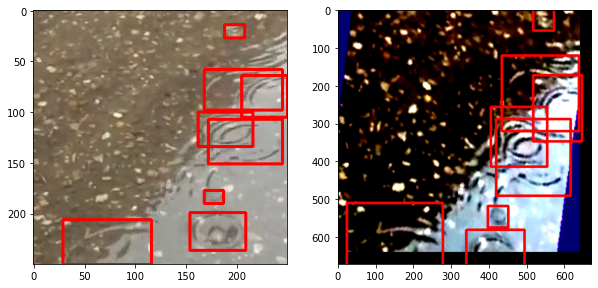

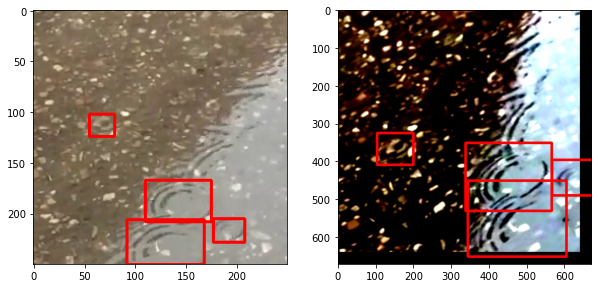

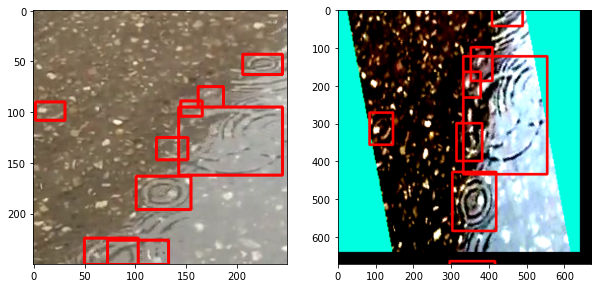

In [5]:
#####################################################
#this cell is to create a dataloaders for detections#
#   in terms of pipeline, the order is as follows   #
#pipeline_augmentations, normalize, augment, resize #
# pipeline is super serious, others are more common #
#####################################################

import cv2
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader


parser.pipeline = 'my_pipeline_v2' #"kitchen_sink" #"my_pipeline_v3" #"rotate" #"my_pipeline_v1"


#adding Augmenter with 50% probability flips the image, and flips the annotations!
dataset_train = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                           transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]), 
                           augment=0.9, pipeline=parser.pipeline, blacken=False)

dataset_train_no_augment = CSVDataset(train_file=parser.csv_train, class_list=parser.csv_classes,
                           transform=transforms.Compose([Normalizer(), Resizer()]), 
                           augment=0, pipeline=parser.pipeline, blacken=False)

dataset_val = CSVDataset(train_file=parser.csv_val, class_list=parser.csv_classes,
                             transform=transforms.Compose([Normalizer(), Resizer()]))    

dataloader_train_detections = DataLoader(dataset_train, num_workers=parser.num_workers, collate_fn=collater, \
                                         batch_size=16, shuffle = True, drop_last = True) 

print("Training data length", len(dataset_train))
print("Validation data length", len(dataset_val))

################################################################
#   if you want to do some snoooping around inside the dataset #
#                  ie this is a unit test                      #
################################################################

import random
for i in range(3):
    image = dataset_train[random.randint(0, len(dataset_train))]
    print("Studying image {}".format(image["filename"]))

    #differences in shade are due to mean/std subtraction in Normalizer
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    annot_to_color = {0 : (255, 0, 0), 1 : (0, 255, 0), 2 : (0, 0, 255), 3 : (255, 215, 0) }
    
    #original image [0, 255]
    for annot in image["original_annot"]:
        x1 = int(annot[0]); y1 = int(annot[1]); x2 = int(annot[2]); y2 = int(annot[3])
        cv2.rectangle(image["original_img"], (x1, y1), (x2, y2), color=annot_to_color[int(annot[4])], thickness=2)  
    ax[0].imshow(image["original_img"])

    #original image [~-2.0, 2.64]
    for annot in image["annot"]:
        x1 = int(annot[0]); y1 = int(annot[1]); x2 = int(annot[2]); y2 = int(annot[3])
        cv2.rectangle(image["img"].numpy(), (x1, y1), (x2, y2), color=annot_to_color[int(annot[4])], thickness=5)  
    ax[1].imshow(image["img"])



In [ ]:
import time

from collections import defaultdict 
from retinanet.train_utils_with_hands import BatchLogger 

retinanet = model.resnet18(num_classes=dataset_train.num_classes(), pretrained=True) #MODIFY LINE 1

retinanet = retinanet.cuda()
retinanet = torch.nn.DataParallel(retinanet).cuda()
retinanet.training = True
optimizer = optim.Adam(retinanet.parameters(), lr=parser.learning_rate)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
loss_hist = collections.deque(maxlen=500)

class_loss = []
reg_loss = []
act_loss = []

retinanet.train()
####################

t0 = time.time() 

best_mAP = 0

for epoch_num in range(parser.epochs+1):
    
    retinanet.train()
    retinanet.module.freeze_bn()
    
    t1 = time.time()
    tot_secs = t1-t0 
    secs = tot_secs % (24 * 3600) 
    hrs = secs // 3600
    secs %= 3600
    mins = secs // 60
    secs %= 60

    epoch_loss = []

    for (iter_num, data) in enumerate(dataloader_train_detections):
        
        optimizer.zero_grad()

        #forward pass the model with both detection data and action/video data
        print("Passing forward shape", data['img'].cuda().float().shape)
        classification_loss, regression_loss, _ = retinanet([data['img'].cuda().float(), data['annot'], torch.tensor([0, 0, 0, 1])])
        
        class_loss.append(float(classification_loss))
        reg_loss.append(float(regression_loss))
                
        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()
        
        loss = classification_loss + regression_loss

        loss.backward()

        torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

        optimizer.step()

        loss_hist.append(float(loss))

        epoch_loss.append(float(loss))

        print('Epoch: {} | Iteration: {} | Classification loss: {:1.4f} | Regression loss: {:1.4f} | Action loss: {:1.4f} | Running loss: {:1.4f}\n '.format(
            epoch_num, iter_num, float(classification_loss), float(regression_loss), float(regression_loss), np.mean(loss_hist)))
    
    #evaluation !
    if epoch_num % 5 == 0:
        print('Evaluating dataset on training detections')
        train_mAP, train_pr = csv_eval.evaluate(dataset_train_no_augment, retinanet, iou_threshold=.5)
        overall_train_mAP = np.mean(np.array([train_mAP[label][0] for label in range(dataset_train.num_classes())])) 
        print("Overall: {}".format(overall_train_mAP)) 
        print("\nEvaluating dataset on val actions")
        val_mAP, val_pr = csv_eval.evaluate(dataset_val, retinanet, iou_threshold=.5)
        overall_val_mAP = np.mean(np.array([val_mAP[label][0] for label in range(dataset_train.num_classes())])) 
        
        val_mAP = val_mAP[0][0]; train_mAP = train_mAP[0][0]
        
        final_mAP = ((train_mAP) * len(dataset_train_no_augment) + (val_mAP) * len(dataset_val)) / \
              (len(dataset_val) + len(dataset_train_no_augment)) 
        print("\n\nTotal average mAP", final_mAP, "\n\n")
        if final_mAP > best_mAP:
            best_mAP = final_mAP
            print("Found new best model!")
            torch.save(retinanet.module, '{}_best.pt'.format(LOG_DIR + parser.model_name))
    
retinanet.eval()

torch.save(retinanet, '{}_final.pt'.format(LOG_DIR + parser.model_name)) 


Creating classification and regression heads
Creating action model
Passing forward shape torch.Size([16, 3, 672, 672])


/pasteur/u/egoodma/multitaskmodel/MULTITASK_FILES/RETINANET_FILES/src/pytorch-retinanet/retinanet/model.py:55: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/aten/src/ATen/native/TensorIterator.cpp:918.)
  P4_x = P5_upsampled_x + P4_x
/pasteur/u/egoodma/multitaskmodel/MULTITASK_FILES/RETINANET_FILES/src/pytorch-retinanet/retinanet/model.py:60: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output channels_last tensor even if some of the inputs are not in channels_last format. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/aten/src/ATen/native/TensorIterator.cpp:924.)
  P3_x = P3_x + P4_upsampled_x


Epoch: 0 | Iteration: 0 | Classification loss: 1.1289 | Regression loss: 1.0631 | Action loss: 1.0631 | Running loss: 2.1920
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 0 | Iteration: 1 | Classification loss: 1.0052 | Regression loss: 0.9822 | Action loss: 0.9822 | Running loss: 2.0897
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 0 | Iteration: 2 | Classification loss: 2.7331 | Regression loss: 1.2372 | Action loss: 1.2372 | Running loss: 2.7166
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 0 | Iteration: 3 | Classification loss: 0.5782 | Regression loss: 1.2648 | Action loss: 1.2648 | Running loss: 2.4982
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 0 | Iteration: 4 | Classification loss: 0.7236 | Regression loss: 0.9788 | Action loss: 0.9788 | Running loss: 2.3390
 
Evaluating dataset on training detections
drop Recall: 0.17407890961262554
drop Precision: 0.02741110577352345

mAP:
drop: 0.01468648390445403
Overall: 0.014

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 8 | Iteration: 2 | Classification loss: 0.5205 | Regression loss: 0.9444 | Action loss: 0.9444 | Running loss: 1.6473
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 8 | Iteration: 3 | Classification loss: 0.5117 | Regression loss: 0.8806 | Action loss: 0.8806 | Running loss: 1.6415
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 8 | Iteration: 4 | Classification loss: 0.4980 | Regression loss: 0.8663 | Action loss: 0.8663 | Running loss: 1.6353
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 9 | Iteration: 0 | Classification loss: 0.5038 | Regression loss: 0.8546 | Action loss: 0.8546 | Running loss: 1.6293
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 9 | Iteration: 1 | Classification loss: 0.4649 | Regression loss: 0.8428 | Action loss: 0.8428 | Running loss: 1.6225
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 9 | Iteration: 2 | Classification loss: 0.4853

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 16 | Iteration: 4 | Classification loss: 0.4247 | Regression loss: 0.7445 | Action loss: 0.7445 | Running loss: 1.4495
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 17 | Iteration: 0 | Classification loss: 0.4029 | Regression loss: 0.7200 | Action loss: 0.7200 | Running loss: 1.4457
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 17 | Iteration: 1 | Classification loss: 0.4497 | Regression loss: 0.7584 | Action loss: 0.7584 | Running loss: 1.4430
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 17 | Iteration: 2 | Classification loss: 0.4008 | Regression loss: 0.7580 | Action loss: 0.7580 | Running loss: 1.4398
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 17 | Iteration: 3 | Classification loss: 0.4109 | Regression loss: 0.7196 | Action loss: 0.7196 | Running loss: 1.4363
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 17 | Iteration: 4 | Classification loss: 

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 25 | Iteration: 3 | Classification loss: 0.3307 | Regression loss: 0.6546 | Action loss: 0.6546 | Running loss: 1.3217
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 25 | Iteration: 4 | Classification loss: 0.4123 | Regression loss: 0.7217 | Action loss: 0.7217 | Running loss: 1.3203
 
Evaluating dataset on training detections
drop Recall: 0.876765423242468
drop Precision: 0.20510035081862574

mAP:
drop: 0.7436944914100923
Overall: 0.7436944914100923

Evaluating dataset on val actions
drop Recall: 0.8617624434389142
drop Precision: 0.20333773342818326

mAP:
drop: 0.6667075924031435


Total average mAP 0.7251606083158267 


Found new best model!
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 26 | Iteration: 0 | Classification loss: 0.4005 | Regression loss: 0.6921 | Action loss: 0.6921 | Running loss: 1.3185
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 26 | Iteration: 1 | Classification 

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 34 | Iteration: 0 | Classification loss: 0.3197 | Regression loss: 0.6285 | Action loss: 0.6285 | Running loss: 1.2436
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 34 | Iteration: 1 | Classification loss: 0.3604 | Regression loss: 0.6470 | Action loss: 0.6470 | Running loss: 1.2422
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 34 | Iteration: 2 | Classification loss: 0.3764 | Regression loss: 0.6588 | Action loss: 0.6588 | Running loss: 1.2410
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 34 | Iteration: 3 | Classification loss: 0.3238 | Regression loss: 0.5902 | Action loss: 0.5902 | Running loss: 1.2392
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 34 | Iteration: 4 | Classification loss: 0.3099 | Regression loss: 0.6168 | Action loss: 0.6168 | Running loss: 1.2374
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 35 | Iteration: 0 | Classification loss: 

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 42 | Iteration: 2 | Classification loss: 0.3368 | Regression loss: 0.6168 | Action loss: 0.6168 | Running loss: 1.1821
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 42 | Iteration: 3 | Classification loss: 0.3226 | Regression loss: 0.5860 | Action loss: 0.5860 | Running loss: 1.1808
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 42 | Iteration: 4 | Classification loss: 0.3211 | Regression loss: 0.5915 | Action loss: 0.5915 | Running loss: 1.1795
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 43 | Iteration: 0 | Classification loss: 0.3207 | Regression loss: 0.6060 | Action loss: 0.6060 | Running loss: 1.1784
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 43 | Iteration: 1 | Classification loss: 0.2687 | Regression loss: 0.5704 | Action loss: 0.5704 | Running loss: 1.1768
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 43 | Iteration: 2 | Classification loss: 

drop Recall: 0.9051651583710407
drop Precision: 0.2168871607511926

mAP:
drop: 0.7646949412648538


Total average mAP 0.8350999943744482 


Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 51 | Iteration: 0 | Classification loss: 0.3138 | Regression loss: 0.5984 | Action loss: 0.5984 | Running loss: 1.1363
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 51 | Iteration: 1 | Classification loss: 0.2508 | Regression loss: 0.5156 | Action loss: 0.5156 | Running loss: 1.1348
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 51 | Iteration: 2 | Classification loss: 0.2647 | Regression loss: 0.5193 | Action loss: 0.5193 | Running loss: 1.1335
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 51 | Iteration: 3 | Classification loss: 0.2837 | Regression loss: 0.5395 | Action loss: 0.5395 | Running loss: 1.1323
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 51 | Iteration: 4 | Classification loss: 0.2790 | Regression loss: 0.5428 | Actio

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 59 | Iteration: 3 | Classification loss: 0.2992 | Regression loss: 0.5879 | Action loss: 0.5879 | Running loss: 1.0963
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 59 | Iteration: 4 | Classification loss: 0.2382 | Regression loss: 0.5354 | Action loss: 0.5354 | Running loss: 1.0952
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 60 | Iteration: 0 | Classification loss: 0.2824 | Regression loss: 0.6010 | Action loss: 0.6010 | Running loss: 1.0945
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 60 | Iteration: 1 | Classification loss: 0.3103 | Regression loss: 0.5455 | Action loss: 0.5455 | Running loss: 1.0938
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 60 | Iteration: 2 | Classification loss: 0.3224 | Regression loss: 0.5854 | Action loss: 0.5854 | Running loss: 1.0931
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 60 | Iteration: 3 | Classification loss: 

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 68 | Iteration: 0 | Classification loss: 0.2753 | Regression loss: 0.5265 | Action loss: 0.5265 | Running loss: 1.0631
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 68 | Iteration: 1 | Classification loss: 0.2682 | Regression loss: 0.5213 | Action loss: 0.5213 | Running loss: 1.0623
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 68 | Iteration: 2 | Classification loss: 0.2591 | Regression loss: 0.5303 | Action loss: 0.5303 | Running loss: 1.0615
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 68 | Iteration: 3 | Classification loss: 0.2368 | Regression loss: 0.5118 | Action loss: 0.5118 | Running loss: 1.0606
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 68 | Iteration: 4 | Classification loss: 0.2486 | Regression loss: 0.4915 | Action loss: 0.4915 | Running loss: 1.0597
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 69 | Iteration: 0 | Classification loss: 

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 76 | Iteration: 2 | Classification loss: 0.2347 | Regression loss: 0.5136 | Action loss: 0.5136 | Running loss: 1.0361
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 76 | Iteration: 3 | Classification loss: 0.3037 | Regression loss: 0.6035 | Action loss: 0.6035 | Running loss: 1.0358
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 76 | Iteration: 4 | Classification loss: 0.2781 | Regression loss: 0.5464 | Action loss: 0.5464 | Running loss: 1.0353
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 77 | Iteration: 0 | Classification loss: 0.3209 | Regression loss: 0.5862 | Action loss: 0.5862 | Running loss: 1.0349
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 77 | Iteration: 1 | Classification loss: 0.2522 | Regression loss: 0.5076 | Action loss: 0.5076 | Running loss: 1.0342
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 77 | Iteration: 2 | Classification loss: 

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 85 | Iteration: 1 | Classification loss: 0.3285 | Regression loss: 0.5890 | Action loss: 0.5890 | Running loss: 1.0107
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 85 | Iteration: 2 | Classification loss: 0.2693 | Regression loss: 0.5283 | Action loss: 0.5283 | Running loss: 1.0102
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 85 | Iteration: 3 | Classification loss: 0.3380 | Regression loss: 0.5704 | Action loss: 0.5704 | Running loss: 1.0099
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 85 | Iteration: 4 | Classification loss: 0.3118 | Regression loss: 0.5781 | Action loss: 0.5781 | Running loss: 1.0097
 
Evaluating dataset on training detections
drop Recall: 0.9467276422764227
drop Precision: 0.22750733840597684

mAP:
drop: 0.931845459917024
Overall: 0.931845459917024

Evaluating dataset on val actions
drop Recall: 0.9104411764705883
drop Precision: 0.22088753609355644

mAP:
drop

Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 93 | Iteration: 3 | Classification loss: 0.2472 | Regression loss: 0.5101 | Action loss: 0.5101 | Running loss: 0.9896
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 93 | Iteration: 4 | Classification loss: 0.2558 | Regression loss: 0.4592 | Action loss: 0.4592 | Running loss: 0.9890
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 94 | Iteration: 0 | Classification loss: 0.2451 | Regression loss: 0.4996 | Action loss: 0.4996 | Running loss: 0.9885
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 94 | Iteration: 1 | Classification loss: 0.2680 | Regression loss: 0.5408 | Action loss: 0.5408 | Running loss: 0.9882
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 94 | Iteration: 2 | Classification loss: 0.2995 | Regression loss: 0.5460 | Action loss: 0.5460 | Running loss: 0.9878
 
Passing forward shape torch.Size([16, 3, 672, 672])
Epoch: 94 | Iteration: 3 | Classification loss: 